# Filtering telluric feature and adding slit info in VIMOS spectra

VIMOS spectra have residual telluric features. The following routine get rid of the most annoying ones.
The header contains only the information about the slits, but not the extracted sources.
Since sometimes a slit contains more than one object, we add this information to the header from an auxiliary
file which was produced when analyzing the data. This files contains the correct coordinates of the targets
and is the one to be used during the analysis of the spectra with showspectra.


In [31]:
def wavfilter(p0, nscale=3, gain=3.3, bias=0, readnoise=6.7, nsigma=5):
    import numpy as np
    from scipy.signal import medfilt
    pp0 = p0 - bias
    npix = len(pp0)
    # mirror the data to avoid border effects ...
    nmirr=2**(nscale+1)+1
    c = np.zeros((2*nmirr+npix,nscale+1))
    w = np.zeros((npix,nscale))

    c[nmirr:nmirr+npix, 0]=pp0
    c[0:nmirr, 0] = np.flip(pp0[0:nmirr]) 
    c[npix+nmirr:npix+2*nmirr, 0] = np.flip(pp0[npix-nmirr:npix])

    for i in range(1, nscale+1):
        c[:,i] = medfilt(c[:, i-1], 2**(i+1)+1)
    for i in range(0,nscale):
        w[:,i] = c[nmirr:nmirr+npix, i] - c[nmirr:nmirr+npix, i+1]
    bgr = c[nmirr:nmirr+npix, nscale]

    # Anscombe transformed coefficients ..
    readnoise=0.0
    tc=0.5*np.sqrt((c/gain+3./8.+(readnoise/gain)**2)>0.) 
    tw = np.zeros((npix,nscale))
    for i in range(nscale):
        tw[:,i]=tc[nmirr:nmirr+npix,i]-tc[nmirr:nmirr+npix,i+1]
        
    mask = np.isfinite(tw[:,0])
    nind = np.sum(mask)
    
    for i in range(5):
        if nind > 10:
            sig = np.sqrt(np.sum(tw[mask,0]**2)/nind)
            mask = np.abs(tw[:,0]) < (3 * sig)
            nind = np.sum(mask)
    sig=sig/0.975

    # 5-sigma cut
    rr = pp0
    for i in range(nscale):
        mask = np.abs(tw[:,i]) <= nsigma*sig
        rr[mask] -= w[mask,i]
        w[mask,i] = 0

    return rr + bias, bgr


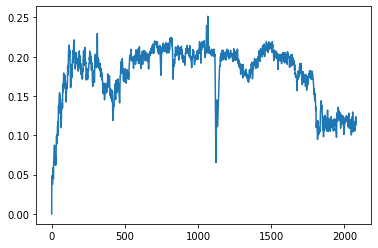

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd

vimos = '01'
quadrant = '1'

catalog = '/home/dario/Python/VIMOS/A85_VIMOS_data_table.csv'
path = '/home/dario/Python/VIMOS/MOSA85V'+vimos+'/QUAD'+quadrant+'/'
file = 'MOSA85V'+vimos+'_MOS_SCIENCE_FLUX_REDUCED'
with fits.open(path+file+'.fits') as hdu:
    ima = hdu[0].data
    h = hdu[0].header

plt.plot(ima[0,:])
plt.show()

# Take away the background and conserve background median level
n = len(ima[:,0])
nw = len(ima[0,:])

imac = ima.copy()
mdbgr = np.zeros(n)
for j in range(n):
    c0 = ima[j,:]
    fc, mc = wavfilter(c0, nscale=7)
    imac[j,:] = (c0 - mc)/np.median(mc)
    mdbgr[j] = np.median(mc)

tell = np.median(imac, axis=0)

# The new spectra will be:
for j in range(n):
    imac[j,:] = ima[j,:] - tell * mdbgr[j]
    
    
# Read the file with ID and coordinates of extracted sources
df = pd.read_csv(catalog)
idvimos = np.array(df.id)
ravimos =  np.array(df.RA)
decvimos =  np.array(df.Dec)
pattern = 'V'+vimos+'Q'+quadrant
idvimos5 = np.array([idv[0:5] for idv in idvimos])
mask = idvimos5 == pattern
idvimos = idvimos[mask]
ravimos = ravimos[mask]
decvimos = decvimos[mask]

for i, (idv, rav, decv) in enumerate(zip(idvimos, ravimos, decvimos)):
    parts = idv.split("_")
    slitid = parts[1]
    h['SLIT_{:02d}_ID'.format(i)] = slitid
    h['SLIT_{:02d}_RA'.format(i)] = rav
    h['SLIT_{:02d}_DEC'.format(i)] = decv
    
# Save new spectrum
hdu = fits.PrimaryHDU(imac)
hdu.header.extend(h)
hdu.writeto(path+file+'_tell.fits',overwrite=True)

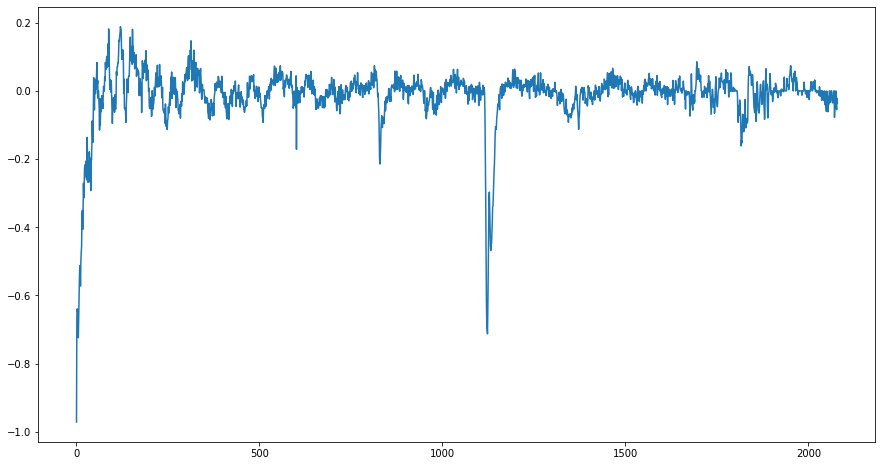

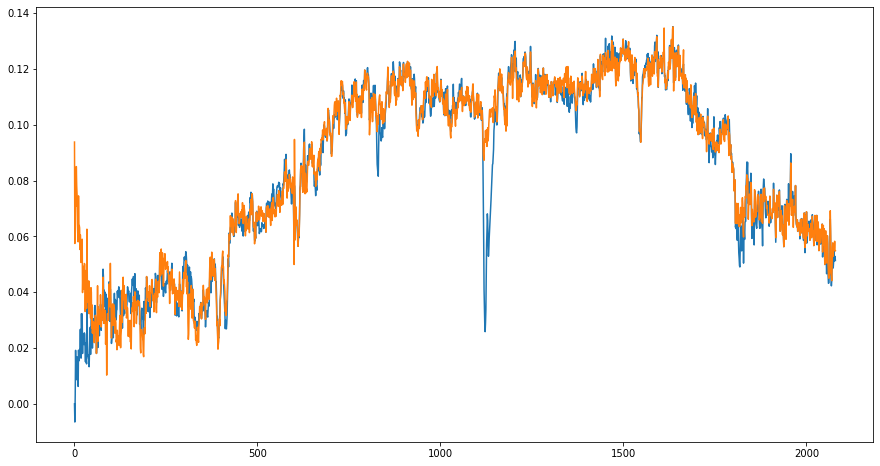

In [41]:
fig=plt.subplots(figsize=(15,8))
plt.plot(tell)
plt.show()

fig=plt.subplots(figsize=(15,8))
plt.plot(ima[1,:])
plt.plot(imac[1,:])
plt.show()

In [88]:
import pandas as pd
import re

vimos = '01'
quadrant = '1'
catalog = '/home/dario/Python/VIMOS/A85_VIMOS_data_table.csv'

catalog = '/home/dario/Python/VIMOS/A85_VIMOS_data_table.csv'
path = '/home/dario/Python/VIMOS/MOSA85V'+vimos+'/QUAD'+quadrant+'/'
file = 'MOSA85V'+vimos+'_MOS_SCIENCE_FLUX_REDUCED'
with fits.open(path+file+'.fits') as hdu:
    ima = hdu[0].data
    h = hdu[0].header


df = pd.read_csv(catalog)
idvimos = np.array(df.id)
ravimos =  np.array(df.RA)
decvimos =  np.array(df.Dec)

pattern = 'V'+vimos+'Q'+quadrant
idvimos5 = np.array([idv[0:5] for idv in idvimos])

mask = idvimos5 == pattern

idvimos = idvimos[mask]
ravimos = ravimos[mask]
decvimos = decvimos[mask]

for i, (idv, rav, decv) in enumerate(zip(idvimos, ravimos, decvimos)):
    parts = idv.split("_")
    slitid = parts[1]
    print('SLIT_{:02d}_ID'.format(i), slitid, rav, decv)
    h['SLIT_'+str(i)+'_ID'] = slitid
    h['SLIT_'+str(i)+'_RA'] = rav
    h['SLIT_'+str(i)+'_DEC'] = decv
    


SLIT_00_ID 20 10.3783 -9.1904
SLIT_01_ID 17 10.3749 -9.1079
SLIT_02_ID 3 10.3699 -9.0936
SLIT_03_ID 22 10.3651 -9.1605
SLIT_04_ID 12 10.3603 -9.1264
SLIT_05_ID 11 10.3513 -9.0899
SLIT_06_ID 10 10.347999999999999 -9.1466
SLIT_07_ID 1 10.3438 -9.1086
SLIT_08_ID 1 -999.9 -999.9
SLIT_09_ID 2 10.3391 -9.1533
SLIT_10_ID 4 10.3304 -9.0994
SLIT_11_ID 8 10.3261 -9.1833
SLIT_12_ID 15 10.3225 -9.0961
SLIT_13_ID 14 10.3164 -9.1227
SLIT_14_ID 7 10.3009 -9.1695
SLIT_15_ID 6 10.295 -9.1715
SLIT_16_ID 6 -999.9 -999.9
SLIT_17_ID 6 10.2986 -9.1715
SLIT_18_ID 16 10.2927 -9.1165
SLIT_19_ID 19 10.2879 -9.1355
SLIT_20_ID 9 10.2856 -9.1415
SLIT_21_ID 13 10.2788 -9.1507
SLIT_22_ID 23 10.2705 -9.1099
SLIT_23_ID 5 10.267999999999999 -9.1451


In [86]:
h

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2080 / length of data axis 1                          
NAXIS2  =                   24 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2015-01-23T09:54:02' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO     '           / European Southern Observatory                  
MJD-OBS =       56568.12906007 / Obs start 2013-10-03T03:05:50.790              
DATE-OBS= '2013-10-03T03:05:50.789' / Date of observation                       
EXPTIME =             1366.9